In [8]:
import statistics
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cuda:0


### Model Setup

In [2]:
batch_size = 64
num_classes = 10
epochs = 5

In [3]:
mnist_train = MNIST(root="data", download=True, transform=transforms.ToTensor(), train=True)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = MNIST(root="data", download=True, transform=transforms.ToTensor(), train=False)

test_loader = DataLoader(mnist_test)

In [4]:
# Feed Forward Neural Network

# model architecture from: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

class Classifier(nn.Module):
    def __init__(self, num_classes: int, activation_function=nn.ReLU(), loss_fn=nn.CrossEntropyLoss()):
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_function,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            activation_function,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 6 * 6, 600),
            nn.Dropout(0.25),
            activation_function,
            nn.Linear(600, 120),
            activation_function,
            nn.Linear(120, num_classes)  # no softmax necessary
        )

        self.num_classes = num_classes
        self.loss_fn = loss_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def train_network(self, dataloader: DataLoader, optimizer: torch.optim.Optimizer):
        self.train()
        losses = []
        for batch, (X, y) in enumerate(tqdm.tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            y_pred = self.forward(X)
            y_true = F.one_hot(y, self.num_classes).type(y_pred.dtype)
            loss = self.loss_fn(y_pred, y_true)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        print(f"Epoch Train Loss: {statistics.mean(losses)}")

    def test(self, dataloader: DataLoader):
        num_batches = len(dataloader)
        self.eval()
        test_loss = 0

        num_correct = 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = self.forward(X)
                test_loss += self.loss_fn(y_pred, F.one_hot(y, self.num_classes).type(y_pred.dtype)).item()
                num_correct += (torch.argmax(y_pred, dim=1) == y).sum().item()
        test_loss /= num_batches
        accuracy = num_correct / len(dataloader.dataset)
        print(f"Test Error: Avg loss: {test_loss:>8f} Accuracy: {float(accuracy):>8f} \n")

In [5]:
model = Classifier(num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1} -------------------------------")
    model.train_network(train_loader, optimizer)
    model.test(test_loader)

Epoch 1 -------------------------------


100%|██████████| 938/938 [00:23<00:00, 39.76it/s]


Epoch Train Loss: 0.12940817666418755
Test Error: Avg loss: 0.042180 Accuracy: 0.986500 

Epoch 2 -------------------------------


100%|██████████| 938/938 [00:22<00:00, 41.90it/s]


Epoch Train Loss: 0.051636295804720636
Test Error: Avg loss: 0.035779 Accuracy: 0.987700 

Epoch 3 -------------------------------


100%|██████████| 938/938 [00:21<00:00, 42.92it/s]


Epoch Train Loss: 0.041357545059270855
Test Error: Avg loss: 0.026999 Accuracy: 0.991100 

Epoch 4 -------------------------------


100%|██████████| 938/938 [00:22<00:00, 41.92it/s]


Epoch Train Loss: 0.031497119946099605
Test Error: Avg loss: 0.042601 Accuracy: 0.986800 

Epoch 5 -------------------------------


100%|██████████| 938/938 [00:21<00:00, 43.12it/s]


Epoch Train Loss: 0.027116872353158534
Test Error: Avg loss: 0.033129 Accuracy: 0.990500 



### Attacks

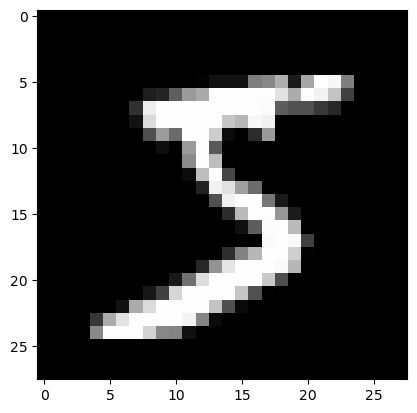

In [9]:
def showImage(image):
    plt.imshow(image[0][0], cmap='gray', interpolation='none')
    plt.show()
showImage(mnist_train[0])
